In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import vectorbt as vbt

import warnings
warnings.filterwarnings('ignore')

# Load daily data
df = pd.read_csv(r"c:\Users\Eddy\YTM Capital Dropbox\Eddy Winiarz\Trading\COF\Models\Unfinished Models\Eddy\Python Projects\BT\data_pipelines\data_processed\with_er_daily.csv", 
                 parse_dates=["Date"]).set_index("Date")
price = df['cad_ig_er_index']

# Compress to Wednesday closes & weekly returns
weekly_idx = price.index[price.index.weekday == 2]  # Wednesday
weekly_price = price.reindex(weekly_idx)  # align
weekly_ret = weekly_price.pct_change()

# Build supervised data-set
data = df.reindex(weekly_idx).copy()  # same rows
data['ret1w'] = weekly_ret
data['target'] = data['ret1w'].shift(-1).gt(0).astype(int)  # next-week sign
data = data.dropna()

X = data.drop(columns=['cad_ig_er_index', 'ret1w', 'target'])
y = data['target']

# Fill any gaps (forward/backward)
X = X.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(method='bfill')

# Fit Gradient Boosting classifier
pipe = Pipeline([('sc', StandardScaler()), 
                 ('gb', GradientBoostingClassifier(max_depth=3,
                                                   n_estimators=200,
                                                   learning_rate=0.05,
                                                   random_state=0))])
pipe.fit(X, y)
proba = pd.Series(pipe.predict_proba(X)[:, 1], index=X.index)

# Threshold sweep to maximise equity
thr_grid = np.arange(0.30, 0.80, 0.02)
best_equity, best_thr = None, None

for thr in thr_grid:
    sig = (proba > thr).astype(int)
    strat_ret = sig * data['ret1w'].shift(-1)  # apply *next* week
    equity = (1 + strat_ret.fillna(0)).cumprod()
    if best_equity is None or equity.iloc[-1] > best_equity.iloc[-1]:
        best_equity, best_thr = equity, thr

# Prepare the data for vectorbt
price_w = weekly_price  # Use the weekly price series you already have
ret_fwd = price_w.pct_change().shift(-1)  # next-week return
y = (ret_fwd > 0).astype(int)  # binary target: 1 = up next week

# Feature engineering - use the X and y you already have from earlier
feat = pd.DataFrame(index=data.index)  # Use the same index as your existing data

# Momentum lags: 1–13 weeks
for k in (1, 2, 4, 8, 13):
    feat[f'ret_{k}'] = price_w.pct_change(k)

# Realised volatility: 4- & 8-week window
feat['vol_4'] = price_w.pct_change().rolling(4).std()
feat['vol_8'] = price_w.pct_change().rolling(8).std()

# Include additional columns from the dataset
extra_cols = [c for c in data.columns if c not in ['cad_ig_er_index', 'ret1w', 'target']]
feat = pd.concat([feat, data[extra_cols]], axis=1)

# Merge features and target, dropping any rows with NaNs
data = pd.concat([feat, y.rename('y')], axis=1).dropna()
X, y = data.drop(columns='y'), data['y']

# First, let's align all series to the same index
# Get the common index
common_idx = weekly_price.index.intersection(proba.index)

# Align all series to this index
price_w = weekly_price.reindex(common_idx)
proba = proba.reindex(common_idx)

# Create entries and exits using the aligned index
entries = proba > best_thr
exits = proba <= best_thr

# Run the backtest
portfolio = vbt.Portfolio.from_signals(
    price_w, 
    entries, 
    exits, 
    freq='W',
    cash_sharing=True  # This helps with cash management
)

# Print the performance metrics
print(portfolio.stats())

print('---------------------------------------------------------------------------------------------')  
print('---------------------------------------------------------------------------------------------') 


# Why is size not always 1 in your backtest?
# Signal-based entries:
# Your signals (entries = proba > best_thr) are binary (True/False), so you might expect a position size of 1 or 0. 
# vectorbt's cash management:
# By default, vectorbt allocates all available capital to a position when a signal is True, but the actual size is calculated based on the available cash, the price at entry, and the portfolio settings.
# cash_sharing=True:
# This means all capital is shared across signals (which matters more if you have multiple columns/assets, but even with one, it can affect sizing if there are fractional cash flows, rounding, or reinvestment effects).
# Fractional sizing:
# If your portfolio grows or shrinks, or if there are floating-point effects, the size can be a float and not exactly 1.
# In your case:
# You are trading a single asset, but vectorbt still computes the maximum possible size you can buy with your available cash at each entry point.
# If your initial cash is 100 and the price is 102, your first trade will have a size of less than 1 (e.g., 0.98), since you can't buy a full unit.
# As your equity grows, you might be able to buy slightly more on the next trade, hence the size changes.


# In vectorbt, the direction column in the trades DataFrame indicates whether a trade is a long or short position:
# direction = 0 means a long trade (buy first, sell later)
# direction = 1 means a short trade (sell first, buy back later)


# status
# Definition:
# Indicates the outcome or state of the trade.
# Typical values:
# 1: Closed — The trade was opened and then closed (i.e., both entry and exit occurred as expected).
# 0: Open — The trade is still open at the end of the backtest (i.e., it was entered but not exited).
# There may be other codes in more complex scenarios (e.g., partially filled trades, but these are rare in simple signal-based backtests).
# In your backtest:

# You’ll typically see status = 1 for trades that were both entered and exited during the backtest period.

# parent_id
# Definition:
# Links a trade to its “parent” trade in the case of trade splitting or chaining, which can happen in more advanced portfolio scenarios (e.g., pyramiding, scaling in/out, overlapping trades).
# Typical values:
# For most simple, non-overlapping trades, parent_id just matches the trade’s own id (e.g., trade 5 has parent_id = 5).
# If a trade was split from a larger trade or is a child of a previous trade (e.g., due to partial exits, scaling, or overlapping positions), parent_id will reference the original trade’s ID.



# Retrieve the trades DataFrame (human-readable format) for further analysis
trades = portfolio.trades.records_readable

# Try to map to expected column names
# Common possibilities: 'Entry Date', 'Exit Date', 'entry_date', 'exit_date'
possible_entry_cols = ['Date Entered', 'Entry Date', 'entry_date']
possible_exit_cols = ['Date Exited', 'Exit Date', 'exit_date']

entry_col = next((col for col in possible_entry_cols if col in trades.columns), None)
exit_col = next((col for col in possible_exit_cols if col in trades.columns), None)

if entry_col is None or exit_col is None:
    print("ERROR: Could not find entry/exit date columns in trades DataFrame.")
    print("Available columns:", trades.columns.tolist())
else:
    # Rename to standard names for consistency
    trades = trades.rename(columns={entry_col: 'Date Entered', exit_col: 'Date Exited'})
    # Ensure datetime conversion
    trades['Date Entered'] = pd.to_datetime(trades['Date Entered'])
    trades['Date Exited'] = pd.to_datetime(trades['Date Exited'])
    # Calculate # Days Held
    trades['# Days Held'] = (trades['Date Exited'] - trades['Date Entered']).dt.days

# Handle possible duplicate columns
if trades.columns.duplicated().any():
    print("WARNING: Duplicate columns detected. Removing duplicates for clarity.")
    trades = trades.loc[:, ~trades.columns.duplicated()]

# Prepare column order for printing, only including columns that exist
cols = ['Date Entered', 'Date Exited', '# Days Held']
cols += [col for col in trades.columns if col not in cols]
cols_to_print = [col for col in cols if col in trades.columns]

print("DEBUG: Printing columns:", cols_to_print)
print(trades[cols_to_print])

Start                         2003-12-10 00:00:00
End                           2025-05-14 00:00:00
Period                         7833 days 00:00:00
Start Value                                 100.0
End Value                              237.299539
Total Return [%]                       137.299539
Benchmark Return [%]                    31.678187
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                         0.541724
Max Drawdown Duration           175 days 00:00:00
Total Trades                                  115
Total Closed Trades                           115
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            93.913043
Best Trade [%]                           7.947712
Worst Trade [%]                         -0.130988
Avg Winning Trade [%]                     0.81518
Avg Losing Trade [%]                    -0.067384


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2003-12-17   2003-12-17
End Period                 2025-05-14   2025-05-14
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       68.0%

Cumulative Return          31.68%       137.3%
CAGR﹪                     0.89%        2.82%

Sharpe                     1.39         7.27
Prob. Sharpe Ratio         99.45%       100.0%
Smart Sharpe               0.89         4.66
Sortino                    1.82         37.14
Smart Sortino              1.16         23.8
Sortino/√2                 1.28         26.26
Smart Sortino/√2           0.82         16.83
Omega                      12.05        12.05

Max Drawdown               -15.39%      -0.54%
Longest DD Days            1429         169
Volatility (ann.)          4.54%        2.69%
R^2                        0.46         0.46
Information Ratio          0.25         0.25
Calmar             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2011-11-16,2011-11-23,2011-12-21,36,-0.541724,-0.414968
2,2020-01-29,2020-02-26,2020-03-25,57,-0.496528,-0.188649
3,2016-05-11,2016-06-29,2016-07-20,71,-0.481517,-0.385788
4,2017-05-10,2017-06-07,2017-06-21,43,-0.356759,-0.346213
5,2013-08-21,2013-09-18,2013-10-16,57,-0.303776,-0.230114


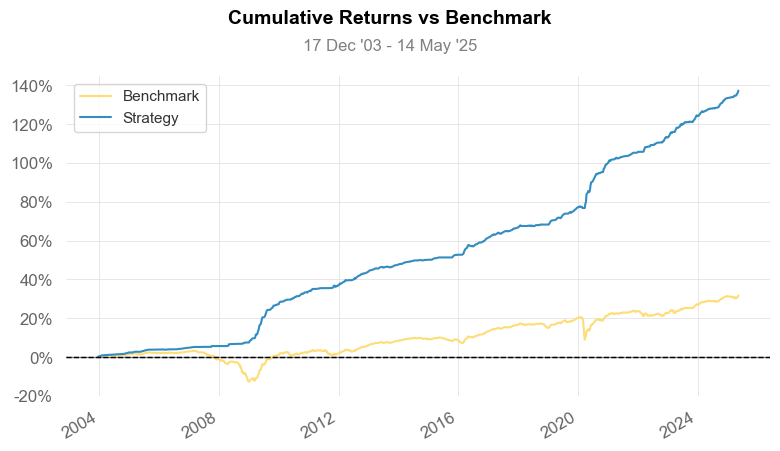

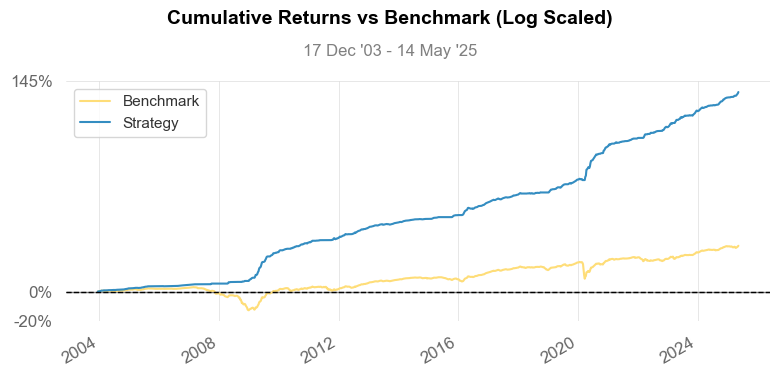

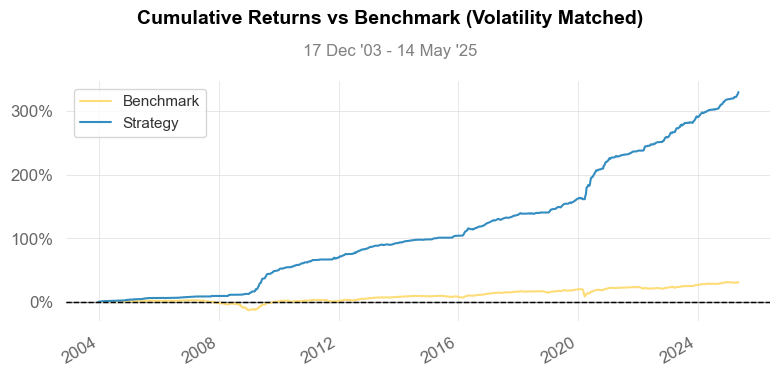

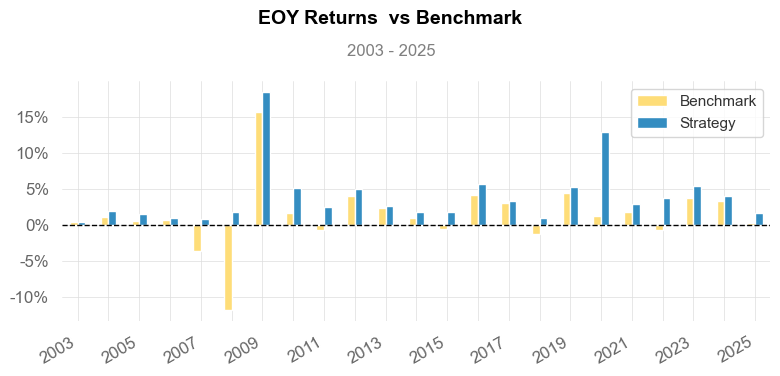

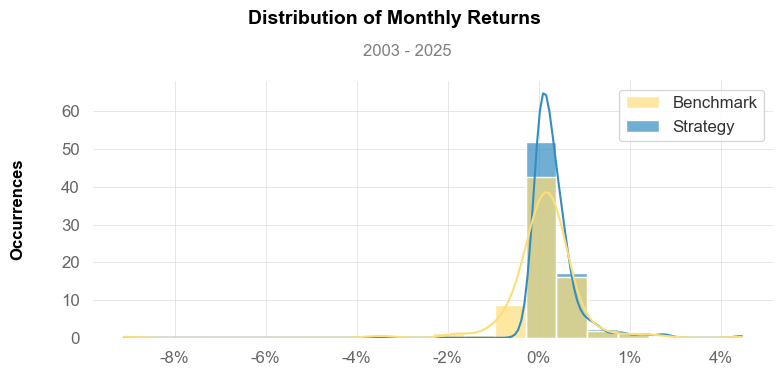

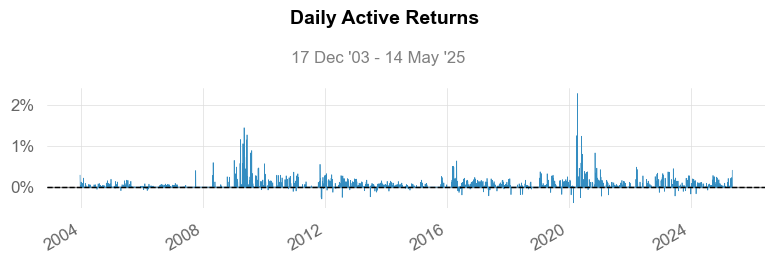

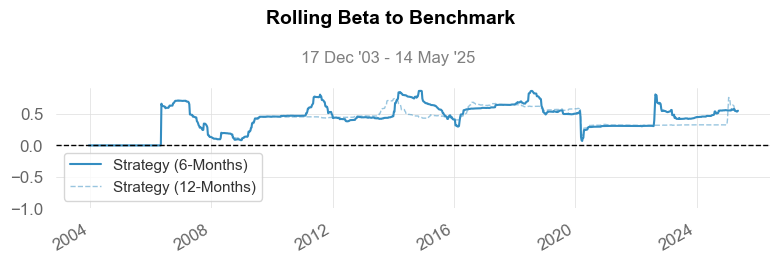

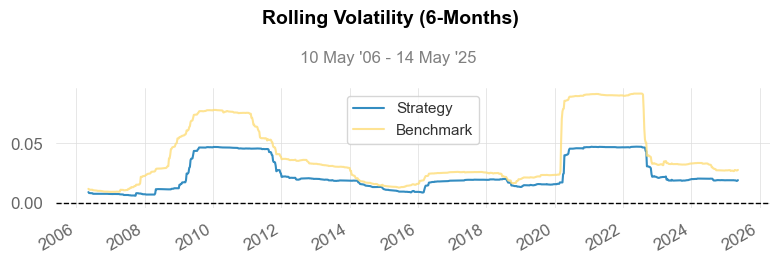

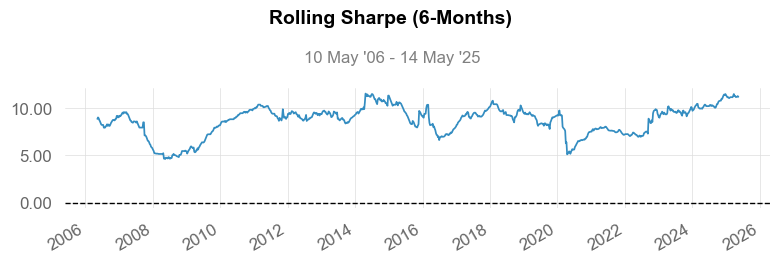

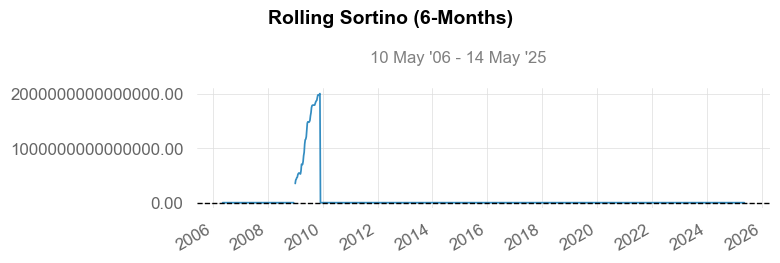

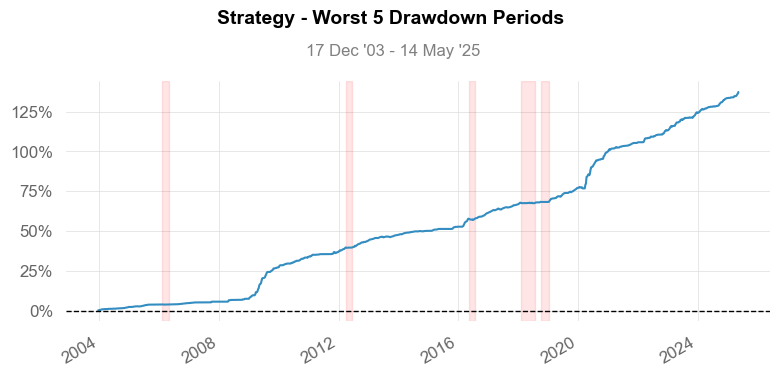

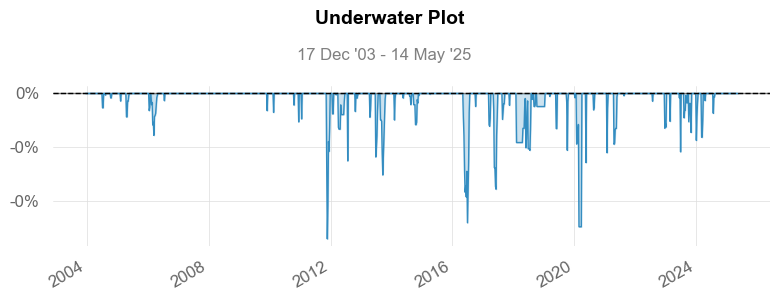

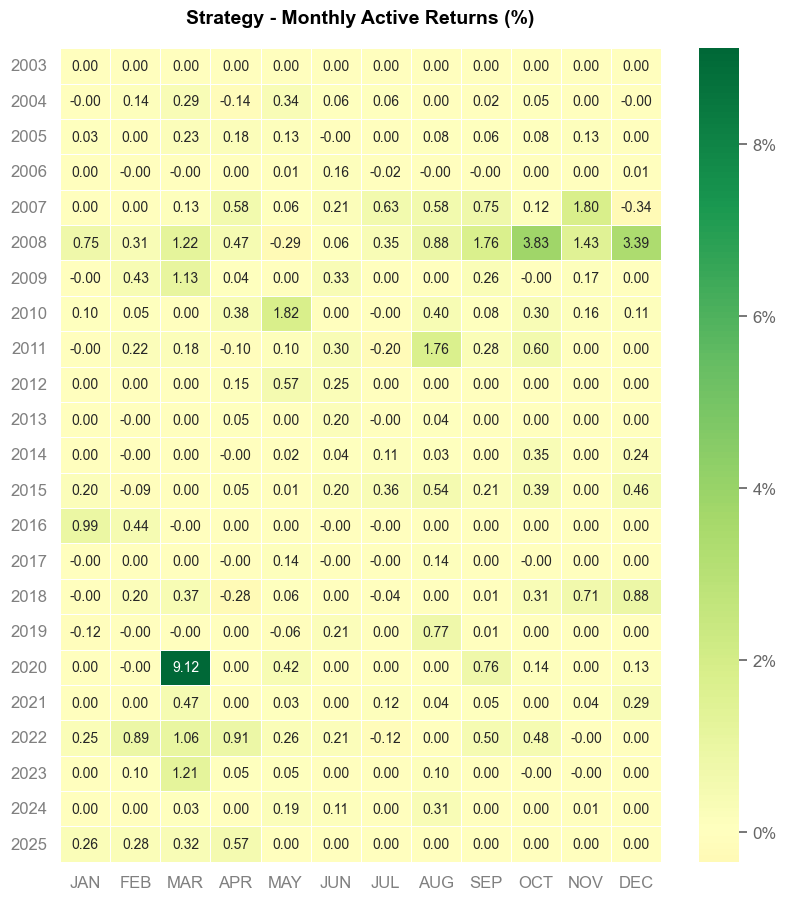

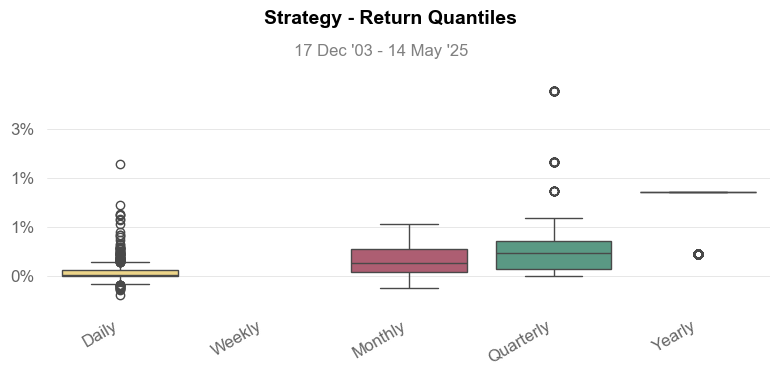

Strategy vs Buy and Hold tearsheet saved to: tearsheets\Gradient Boosting, Weekly Model on cad_ig_er_index.html


In [17]:
import os
import quantstats as qs
import numpy as np

# Ensure the output directory exists
output_dir = 'tearsheets'
os.makedirs(output_dir, exist_ok=True)
output_path_bh = os.path.join(output_dir, 'Gradient Boosting, Weekly Model on cad_ig_er_index.html')

# For the Buy and Hold tearsheet, you'll use portfolio.returns() as your strategy 
# and buyhold_returns as the benchmark
strategy_returns = portfolio.returns()
benchmark_returns = price_w.pct_change().reindex(strategy_returns.index).fillna(0)
benchmark_returns = benchmark_returns.replace([np.inf, -np.inf], np.nan).dropna()

# Generate the full tearsheet with benchmark comparison
qs.reports.full(
    strategy_returns,
    benchmark=benchmark_returns,  # This adds benchmark comparison
    title='Weekly Gradient Boosting vs Buy and Hold',
    freq='W'
)

# Save the HTML report with benchmark comparison
qs.reports.html(
    strategy_returns,
    benchmark=benchmark_returns,  # This adds benchmark comparison
    output=output_path_bh,
    title='Weekly Gradient Boosting vs Buy and Hold',
    freq='W'
)

print(f"Strategy vs Buy and Hold tearsheet saved to: {output_path_bh}")